In [46]:
from collections import defaultdict
import numpy as np

minmax_x = [9999999999999, -9999999999999]
minmax_y = [9999999999999, -9999999999999]

pos_dic = defaultdict(lambda: [])
with open("data/baristaseq/mouse/all_spots.csv") as f:
    print(f.readline())
    for line in f:
        entries = line.rstrip().split(',')
        x = float(entries[3])
        y = float(entries[4])
        g = entries[10]
        if "unused" in g:
            continue
        pos_dic[g].append([x, y])
        if x < minmax_x[0]:
            minmax_x[0] = x
        if x > minmax_x[1]:
            minmax_x[1] = x
        if y < minmax_y[0]:
            minmax_y[0] = y
        if y > minmax_y[1]:
            minmax_y[1] = y
for g in pos_dic:
    pos_dic[g] = np.array(pos_dic[g])

,Gene ID,Cell ID,x,y,x(tile),y(tile),Dist to pia,Dist to bottom,angle,gene



In [29]:
dup_dic = set()
with open("data/baristaseq/mouse/all_spots.csv") as f:
    f.readline()
    for line in f:
        l = line.rstrip()
        if l in dup_dic:
            print(l)
            break
        dup_dic.add(l)

In [19]:
all_genes = sorted(pos_dic.keys())
mrna_loci = [pos_dic[gene] for gene in all_genes]

In [10]:
minmax_x, minmax_y

([16.7375, 1471.76], [16.7375, 1474.72])

In [12]:
width, height = 1500, 1500

In [4]:
import ssam

In [21]:
ds = ssam.SSAMDataset(all_genes, mrna_loci, width, height)
analysis = ssam.SSAMAnalysis(ds, ncores=10, save_dir="data/baristaseq_mouse", verbose=True)

In [22]:
analysis.run_fast_kde(bandwidth=2.5, use_mmap=False)

Processing gene Adarb2...
Processing gene Adcy2...
Processing gene Ank1...
Processing gene Ankrd55...
Processing gene Arpp19...
Processing gene Arx...
Processing gene Atp1a3...
Processing gene Brinp3...
Processing gene Btbd11...
Processing gene Cacna2d3...
Processing gene Calb1...
Processing gene Caln1...
Processing gene Car3...
Processing gene Car4...
Processing gene Cck...
Processing gene Chodl...
Processing gene Chrna2...
Processing gene Cnr1...
Processing gene Crh...
Processing gene Cryab...
Processing gene Ctxn1...
Processing gene Cxcl14...
Processing gene Dcn...
Processing gene Deptor...
Processing gene Dlx1...
Processing gene Dlx6...
Processing gene Fa2h...
Processing gene Fezf2...
Processing gene Fgfr3...
Processing gene Gad1...
Processing gene Gad2...
Processing gene Gm11549...
Processing gene Id2...
Processing gene Igfbp6...
Processing gene Itpka...
Processing gene Kcnip1...
Processing gene Kcnip4...
Processing gene Kcnmb2...
Processing gene Lamp5...
Processing gene Lhx6...
P

In [24]:
import matplotlib.pyplot as plt

In [32]:
len(ds.genes)

79

(200, 400)

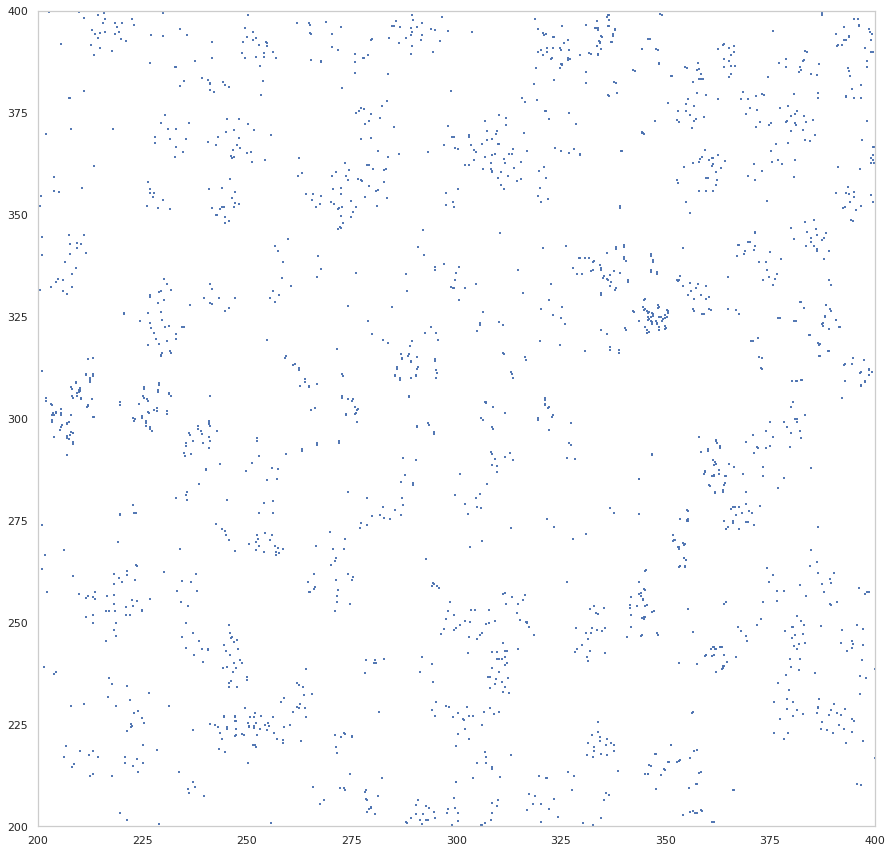

In [45]:
plt.figure(figsize=[15, 15])
plt.scatter(pos_dic[ds.genes[0]][:, 1], pos_dic[ds.genes[0]][:, 0], s=1, marker=",")
plt.xlim([200, 400])
plt.ylim([200, 400])

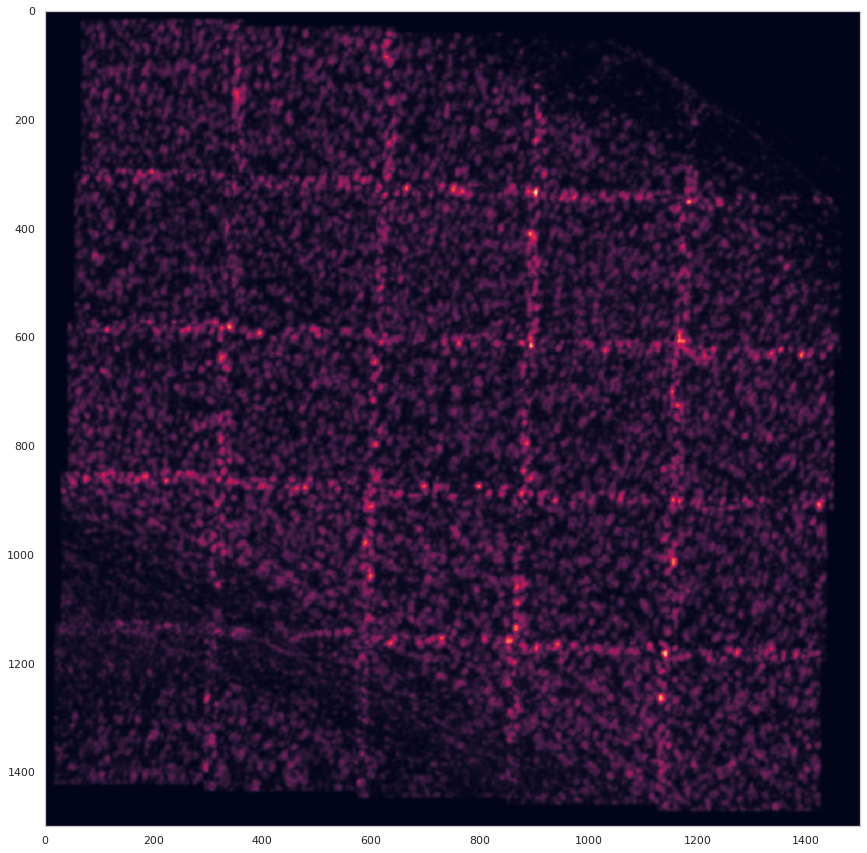

In [299]:
plt.figure(figsize=[15, 15])
plt.imshow(ds.vf_norm[..., 0])

In [47]:
exp_thres = 0
norm_thres = 0

In [48]:
analysis.find_localmax(search_size=3, min_expression=exp_thres, min_norm=norm_thres)

Found 7008 local max vectors.


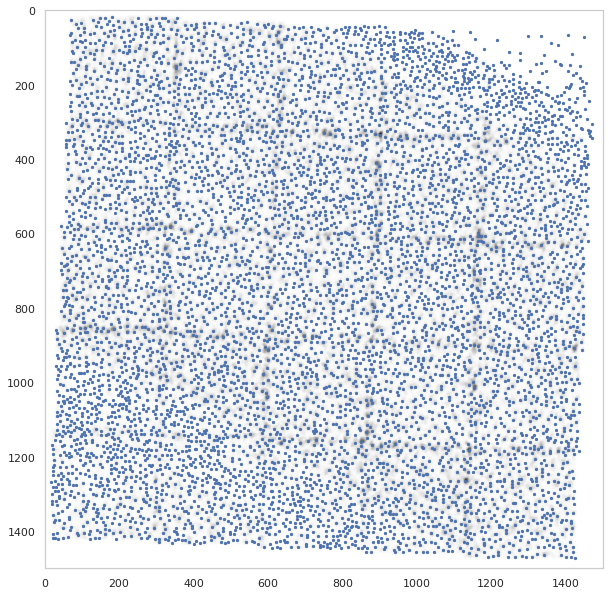

In [49]:
plt.figure(figsize=[10, 20])
ds.plot_l1norm(cmap="Greys")
ds.plot_localmax(s=5)

In [50]:
analysis.normalize_vectors_sctransform(vst_kwargs=dict(min_cells=1))

In [69]:
analysis.cluster_vectors(pca_dims=33, resolution=0.6, max_correlation=1.0, metric="correlation", centroid_correction_threshold=0.6)

Found 26 clusters


In [71]:
analysis.map_celltypes()
analysis.filter_celltypemaps(min_norm=0.5, min_r=0.6)

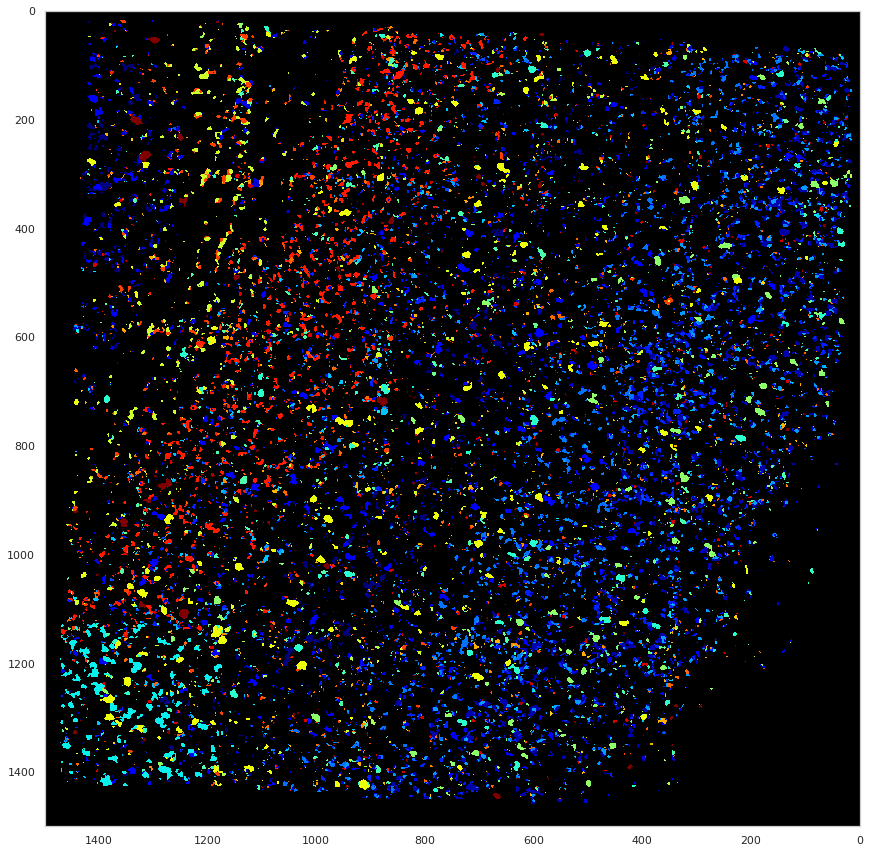

In [72]:
plt.figure(figsize=[15,15])
_=ds.plot_celltypes_map(rotate=True,)#colors=colors,background='white')#,set_alpha=True)

In [266]:
#import pickle
#class ColDict:
#    def __getitem__(self, s):
#        rtn = None
#        for d in self.col_dics:
#            rtn = d.get(s, None)
#            if rtn is not None:
#                break
#        if rtn is None:
#            raise KeyError(s)
#        return rtn
#with open("scrna_signatures_mouse_visp_mean_exon_counts.pkl", "rb") as f:
#        scrna_genes, scrna_clusters, scrna_full_centroids, scrna_col_dict = pickle.load(f)
#scrna_uniq_clusters = np.unique(scrna_clusters)
#selected_genes_idx = [list(scrna_genes).index(g) for g in ds.genes]
#scrna_centroids = scrna_full_centroids[:, selected_genes_idx]
#scrna_colors = [scrna_col_dict[cl] for cl in scrna_uniq_clusters]

In [286]:
with open("scrna_sigs.pkl", "rb") as f:
    scrna_clusters, scrna_genes, scrna_full_centroids, scrna_colors = pickle.load(f)

In [287]:
gene_conv_dic ={
    "Ngfrap1": "Bex3",
    "Gucy1a3": "Gucy1a1",
    "Ppap2b": "Plpp3",
    "Selm": "Selenom",
    "3110035E14Rik": "Vxn",
    "Ppapdc1a": "Plpp4",
    "Fam84b": "Lratd2"
}

In [288]:
for f, t in gene_conv_dic.items():
    scrna_genes = np.where(scrna_genes == f, t, scrna_genes)

In [290]:
selected_genes_idx = [list(scrna_genes).index(g) for g in ds.genes]
scrna_uniq_clusters = np.unique(scrna_clusters)
scrna_centroids = scrna_full_centroids[:, selected_genes_idx]

In [294]:
analysis.map_celltypes(scrna_centroids)
analysis.filter_celltypemaps(min_norm=0.6, min_r=0.3)

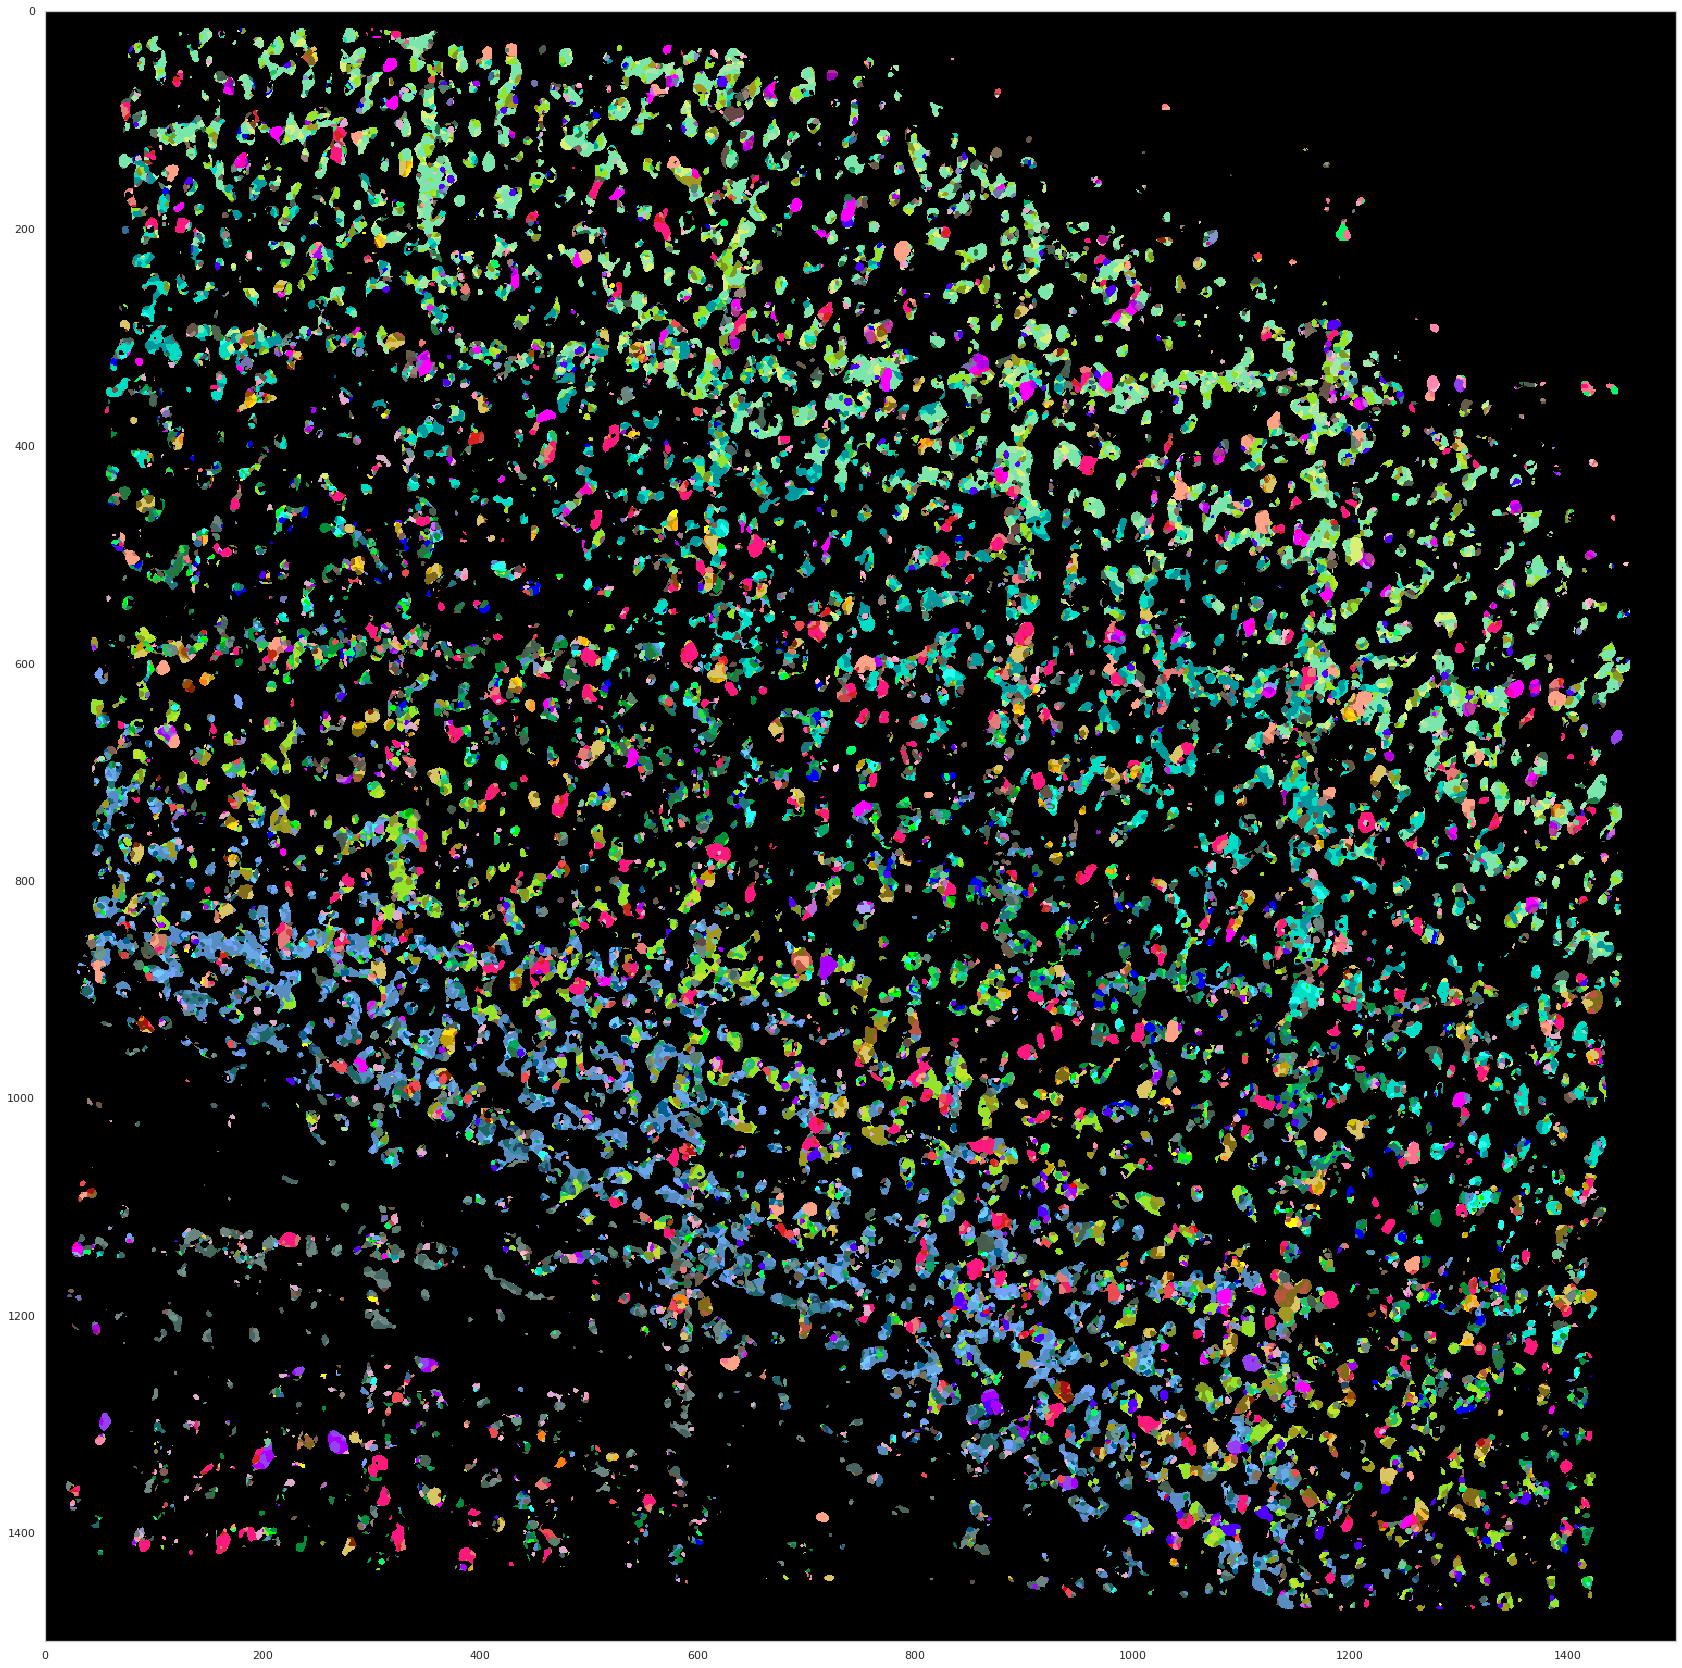

In [295]:
plt.figure(figsize=[30,30])
_ = ds.plot_celltypes_map(rotate=0, colors=scrna_colors)

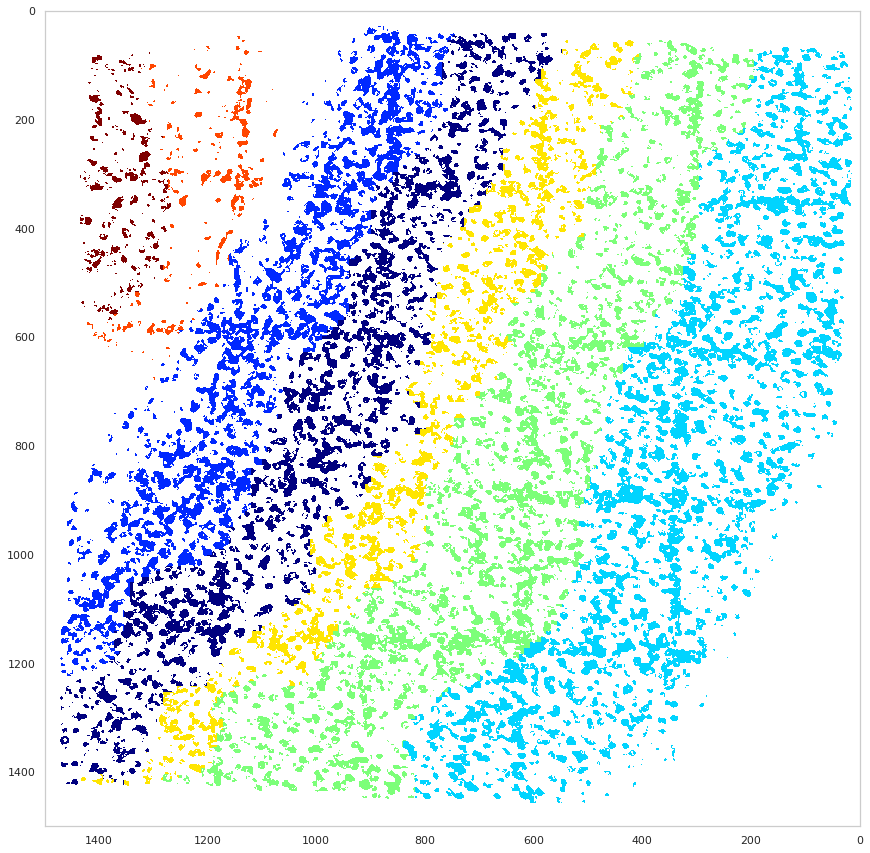

In [296]:
analysis.bin_celltypemaps(step=10, radius=100)
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.8, norm_thres=1500)
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=1)

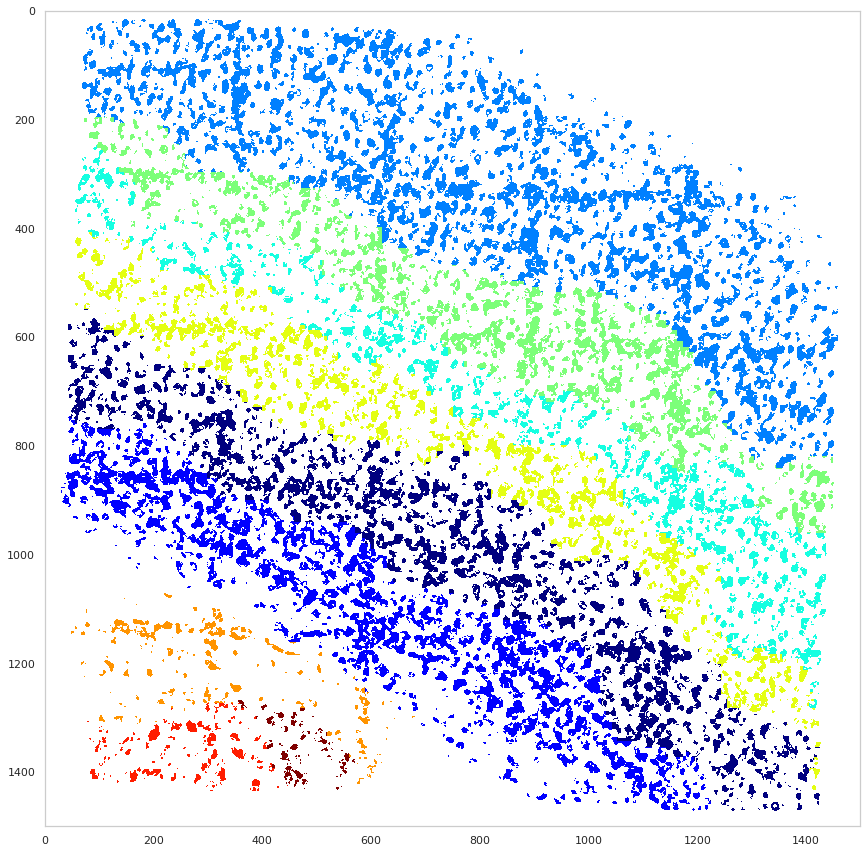

In [297]:
analysis.bin_celltypemaps(step=10, radius=100)
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.8, norm_thres=1500)
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=0)

In [126]:
#import pickle
#with open("scrna_sigs.pkl", "rb") as f:
#    scrna_cl_names, scrna_genes, scrna_full_centroids, scrna_colors = pickle.load(f)

In [238]:
#np.array(ds.genes)[np.where([not g in scrna_genes for g in ds.genes])]

array(['Lratd2', 'Plpp4', 'Vxn'], dtype='<U8')

In [207]:
#selected_genes_idx = [list(scrna_genes).index(g) for g in ds.genes]
#scrna_uniq_clusters = np.unique(scrna_cl_names)
#scrna_centroids = scrna_full_centroids[:, selected_genes_idx]

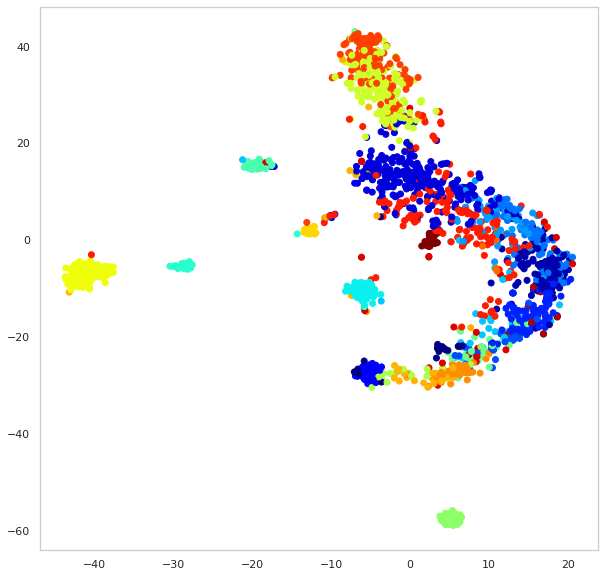

In [144]:
plt.figure(figsize=[10, 10])
ds.plot_tsne(run_tsne=True)

In [175]:
annot_list = []
with open("spot_annot.csv", "r") as f:
    f.readline()
    for line in f:
        annots = line.rstrip().split(',')
        annot_list.append(annots[2])
annot_list = np.array(annot_list)

In [196]:
viktor_centroids = []
viktor_cluster_colors = []
for cl in np.unique(annot_list):
    print(cl)
    viktor_cluster_colors.append(col_dic[cl])
    viktor_centroids.append(
        np.mean(ds.normalized_vectors[annot_list == cl], axis=0)
    )

ALM L2/3 IT Sla
Astro
L4
Lamp5 Egln3_2
Lamp5 Slc35d3
OPC Pdgfra
Oligo Opalin
PVM Mrc1
Pvalb Th
Sst Etv1_4
Sst Hpse_2
VISp L2/3 IT Agmat
VISp L5 IT Batf3
VISp L5 IT Hsd11b1
VISp L5 PT C1ql2
VISp L5 PT Chrna6
VISp L6 CT Adcyap1
VISp L6 CT Gpr139
VISp L6 IT Marcksl1
VLMC Slc47a1
Vip C1ql1


In [216]:
analysis.map_celltypes(viktor_centroids)
analysis.filter_celltypemaps(min_norm=0.6, min_r=0.4)

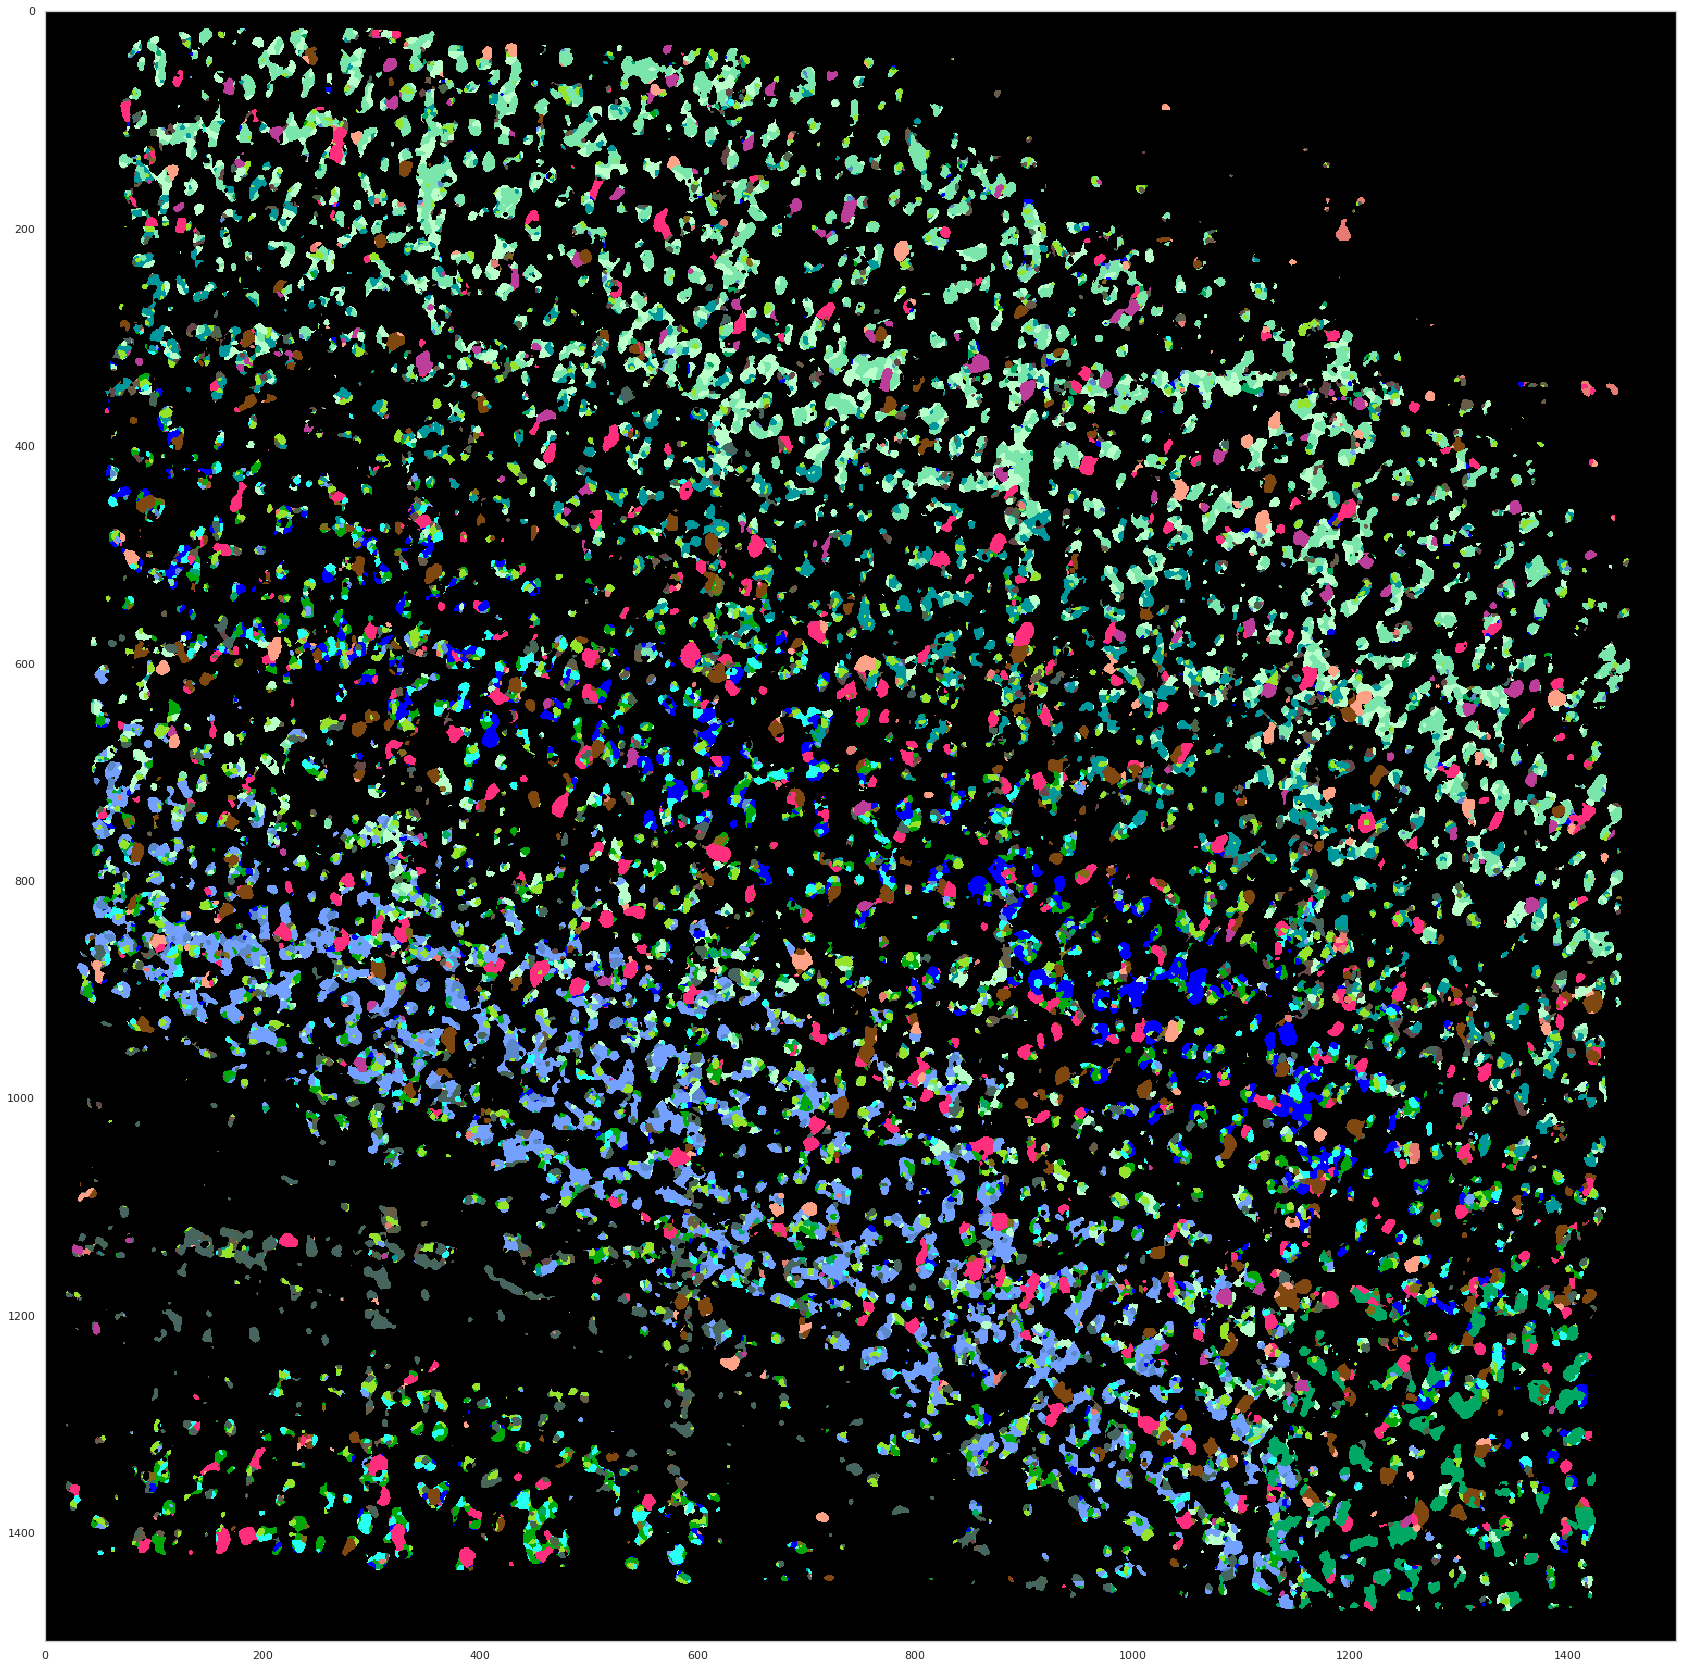

In [217]:
plt.figure(figsize=[30,30])
_=ds.plot_celltypes_map(rotate=0, colors=viktor_cluster_colors)

In [176]:
annot_list

array(['VISp L5 IT Hsd11b1', 'VISp L6 CT Gpr139', 'OPC Pdgfra', ...,
       'VISp L5 PT C1ql2', 'ALM L2/3 IT Sla', 'VISp L5 PT C1ql2'],
      dtype='<U19')

In [145]:
import os
from scipy.stats import pearsonr, spearmanr

diagdir = "diagplots_baristaseq_mouse"

if not os.path.exists(diagdir):
    os.mkdir(diagdir)

for idx in range(len(ds.centroids)):
    plt.figure(figsize=[50, 15])
    ds.plot_diagnostic_plot(idx, known_signatures=[
        ("scRNA-seq", scrna_cl_names, scrna_centroids, scrna_colors),
    ], correlation_methods=[
        ("r", pearsonr),
        ("rho", spearmanr)
    ])
    plt.tight_layout()
    plt.savefig(diagdir + '/diagplot_centroid_%d.png'%idx)
    plt.close()

In [157]:
with open("viktor_normalized_vectors.pkl", "wb") as f:
    pickle.dump([ds.genes, ds.normalized_vectors], f)

In [73]:
analysis.bin_celltypemaps(step=10, radius=100)
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.7, norm_thres=1500)
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=1)

In [89]:
analysis.find_domains(n_clusters=20, merge_remote=False, merge_thres=0.7, norm_thres=1500)

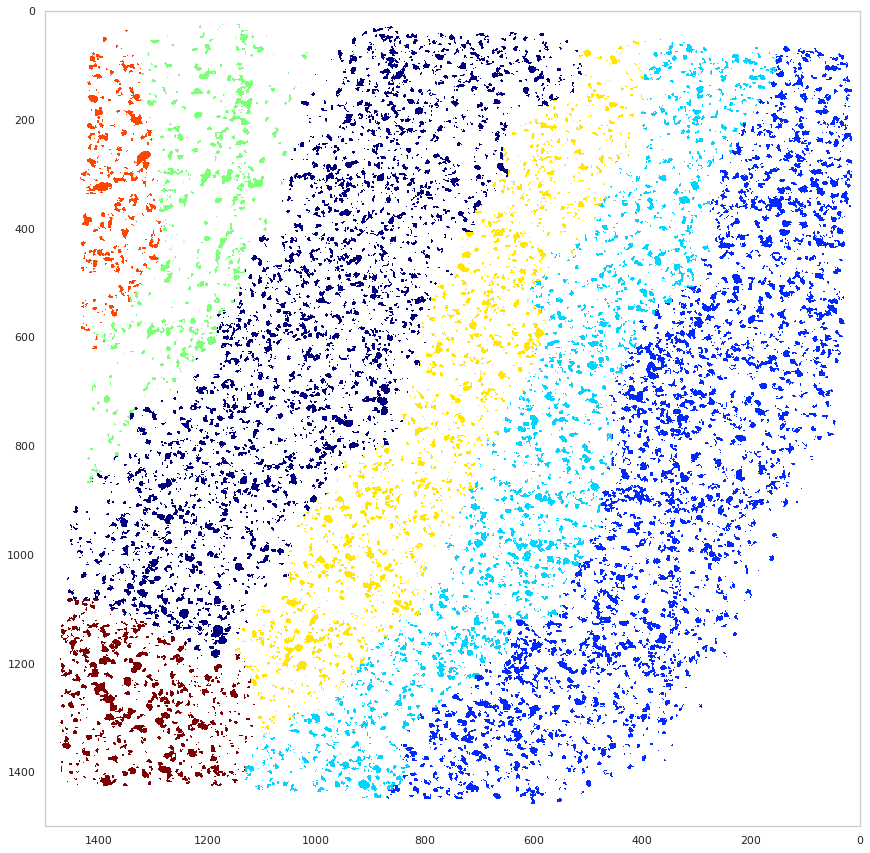

In [90]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=[15, 15])
ds.plot_domains(rotate=1)

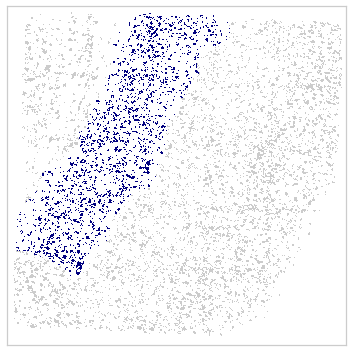

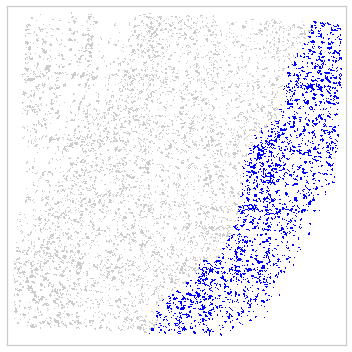

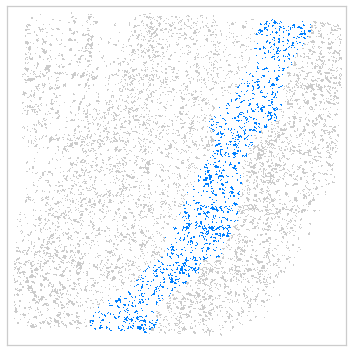

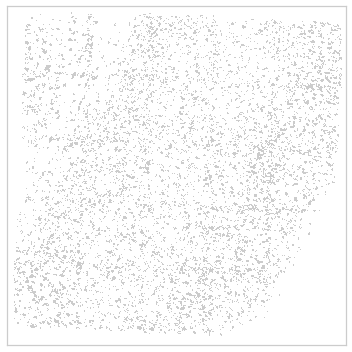

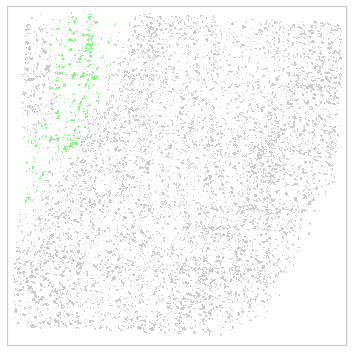

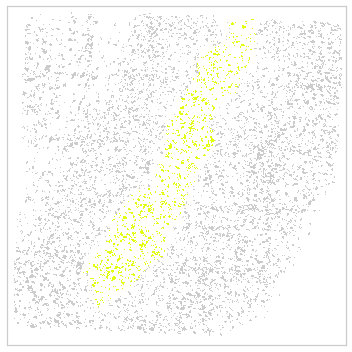

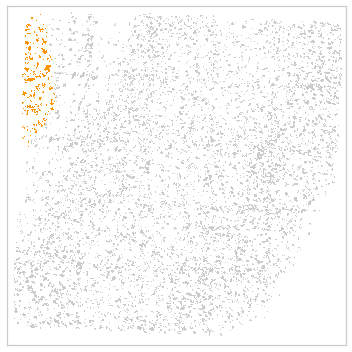

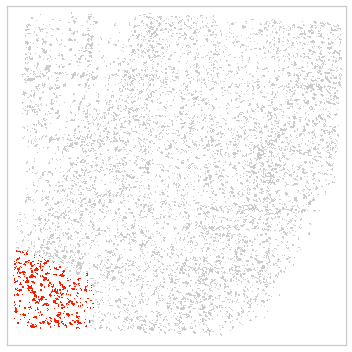

In [94]:
# Check found domains
from matplotlib.colors import ListedColormap
cmap_jet = plt.get_cmap('jet')
num_domains = np.max(ds.inferred_domains_cells) + 2
for domain_idx in range(num_domains):
    plt.figure(figsize=[5, 5])
    cmap = ListedColormap([cmap_jet(lbl_idx / num_domains) if domain_idx == lbl_idx else "#cccccc" for lbl_idx in range(num_domains)])
    ds.plot_domains(rotate=1, cmap=cmap)
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    plt.tight_layout()

In [95]:
analysis.calc_cell_type_compositions()

In [101]:
np.where(ds.inferred_domains_compositions[0] > 0.1)[0], np.where(ds.inferred_domains_compositions[5] > 0.1)[0]

(array([22]), array([0, 2, 3]))

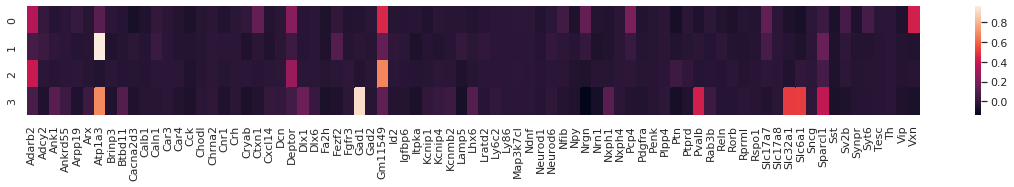

In [104]:
plt.figure(figsize=[20,2])
sns.heatmap(ds.centroids[(22, 0, 2, 3), :], xticklabels=ds.genes)

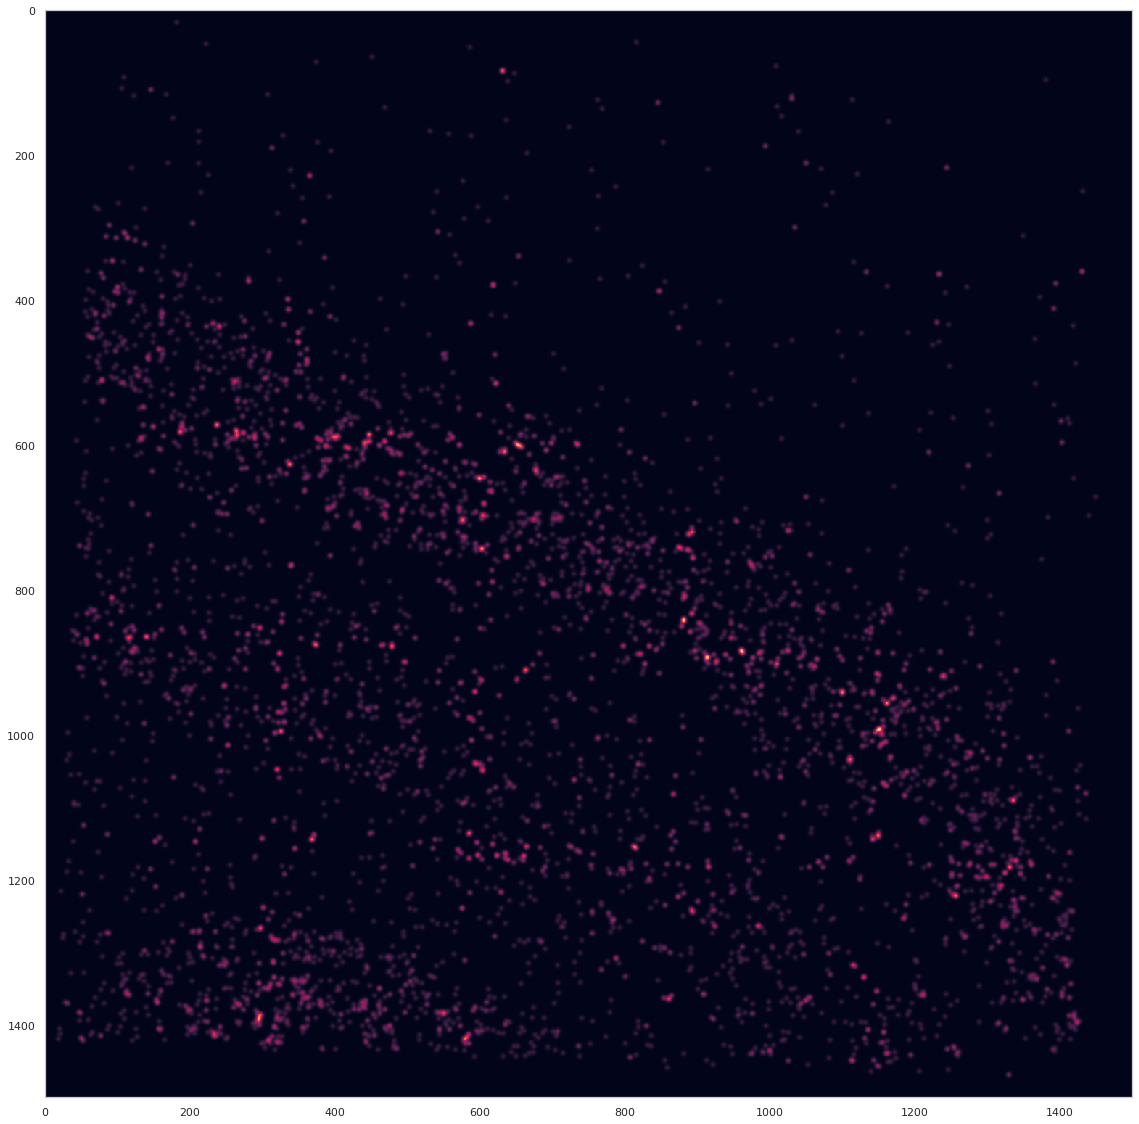

In [125]:
plt.figure(figsize=[20, 20])
plt.imshow(ds.vf[..., 0, ds.genes.index("Fezf2")])

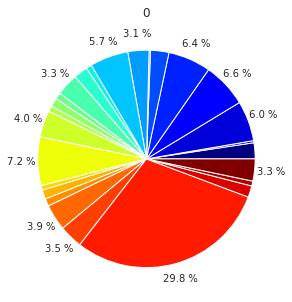

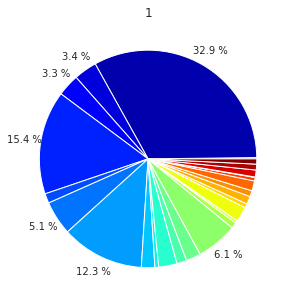

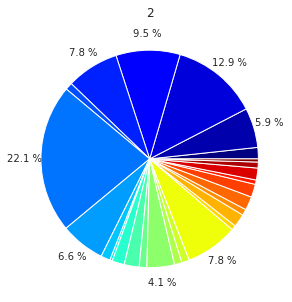

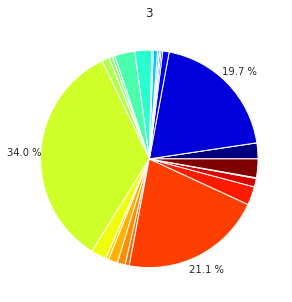

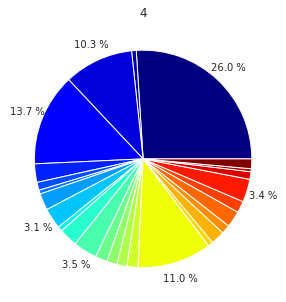

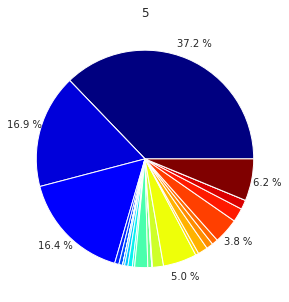

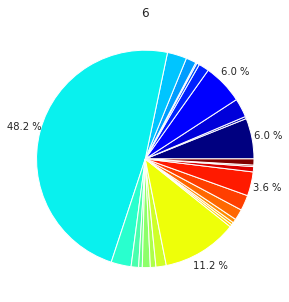

In [96]:
for domain_idx in range(7):
    plt.figure(figsize=[5, 5])
    ds.plot_celltype_composition(domain_idx,
                                 label_cutoff=0.03)
    plt.title(domain_idx)

In [64]:
import seaborn as sns

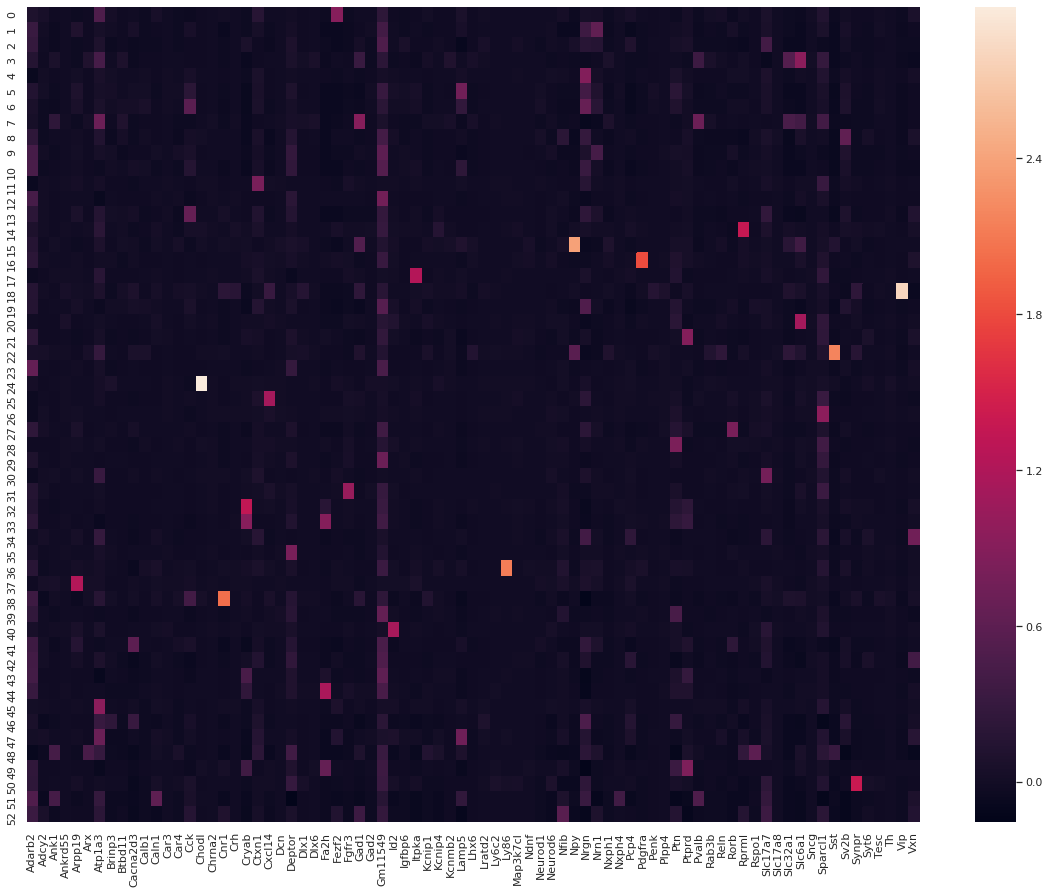

In [67]:
plt.figure(figsize=[20, 15])
sns.heatmap(ds.centroids, xticklabels=ds.genes)